In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
 
    
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-default-risk/application_test.csv
/kaggle/input/home-credit-default-risk/installments_payments.csv
/kaggle/input/home-credit-default-risk/application_train.csv
/kaggle/input/home-credit-default-risk/HomeCredit_columns_description.csv
/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv
/kaggle/input/home-credit-default-risk/sample_submission.csv
/kaggle/input/home-credit-default-risk/bureau.csv
/kaggle/input/home-credit-default-risk/credit_card_balance.csv
/kaggle/input/home-credit-default-risk/previous_application.csv
/kaggle/input/home-credit-default-risk/bureau_balance.csv


In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
train = pd.read_csv("/kaggle/input/home-credit-default-risk/application_train.csv")
test = pd.read_csv("/kaggle/input/home-credit-default-risk/application_test.csv")
sample_submission = pd.read_csv("/kaggle/input/home-credit-default-risk/sample_submission.csv")

In [92]:
pd.options.display.max_columns = 200

In [93]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

# Подготовка данных
Посколькую деревья не требуют специальной подготовки данных и целью ДЗ не ставится достижение score, то в качестве выборки возьмем 10 признаков из предыдущего ДЗ по линейной регрессии.

Также, по скольку деревья "слабы" в предсказании и полезны в аналитике, то для ДЗ, в качестве тренировочной и обучающей выборки будем использовать данные только из train, предварительно разбив их на две части (для кросс-валидации).

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [12]:
selected_heads = ['SK_ID_CURR', 'AMT_INCOME_TOTAL','AMT_ANNUITY', 'AMT_CREDIT', 'REGION_POPULATION_RELATIVE', 'OWN_CAR_AGE', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'REGION_RATING_CLIENT', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BUILD_AVG', 'ENTRANCES_AVG', 'NONLIVINGAREA_AVG', 'FLOORSMAX_MEDI', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_8', 'AMT_REQ_CREDIT_BUREAU_YEAR']

# TODO: добавить

for i, _head in enumerate(selected_heads):
    train[_head].fillna(0, inplace = True)
        
print('fillina done')

fillina done


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    train, train['TARGET'], test_size=0.33, random_state=42)

# Решающее дерево

В качестве гиперпараметров возьмем:  
max_features=["auto", "sqrt", "log2", None]  
max_depth = [1, .., 10]  
presort = [true, false]


In [97]:
from sklearn.tree import DecisionTreeClassifier

0.5991713789328358 0.5991359426272979
0.6617738630937242 0.6597774586527648
0.6863030747004071 0.6844583808293712
0.6977680612270452 0.6965905894506885
0.7105489881259779 0.7076452431168708
0.7196303168143005 0.7128501966182299
0.7263304691504575 0.7126623015753698
0.7340076026109492 0.7123851062267804
0.7415163365949611 0.7101312689620224


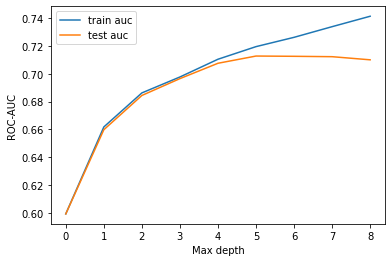

In [111]:
# max_depth
auc_train_list = []
auc_test_list = []

for m_d in range(1, 10):
    clf1 = DecisionTreeClassifier(max_depth=m_d,max_features=None, presort=False)
    clf1.fit(X_train[selected_heads], y_train )
    predict_test = clf1.predict_proba(X_test[selected_heads] )[:,1]
    predict_train = clf1.predict_proba(X_train[selected_heads] )[:,1]
    
    auc_test = roc_auc_score(y_test, predict_test )
    auc_train = roc_auc_score(y_train, predict_train )
    print(auc_train, auc_test )
    
    auc_train_list.append(auc_train)
    auc_test_list.append(auc_test)
    
plt.plot(auc_train_list, label = 'train auc')
plt.plot(auc_test_list, label = 'test auc')
plt.xlabel('Max depth')
plt.ylabel('ROC-AUC')
plt.legend()
plt.show()


0.6845529694078784 0.6768327303765325
0.6632470333305922 0.6585995097190405
0.6450225834871522 0.6393596586608158
0.7196303168143005 0.7128364928246476


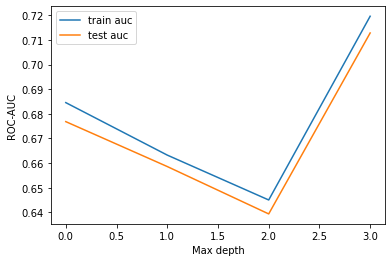

In [107]:
# max_features
auc_train_list = []
auc_test_list = []

mx_fch=["auto", "sqrt", "log2", None]

for i, mx in enumerate(mx_fch):
    clf1 = DecisionTreeClassifier(max_depth=6, max_features=mx, presort=False)
    clf1.fit(X_train[selected_heads], y_train )
    predict_test = clf1.predict_proba(X_test[selected_heads] )[:,1]
    predict_train = clf1.predict_proba(X_train[selected_heads] )[:,1]
    
    auc_test = roc_auc_score(y_test, predict_test )
    auc_train = roc_auc_score(y_train, predict_train )
    print(auc_train, auc_test )
    
    auc_train_list.append(auc_train)
    auc_test_list.append(auc_test)
    
plt.plot(auc_train_list, label = 'train auc')
plt.plot(auc_test_list, label = 'test auc')
plt.xlabel('max_features')
plt.ylabel('ROC-AUC')
plt.legend()
plt.show()

In [17]:
# presort
auc_train_list = []
auc_test_list = []
_presort = [True, False]

for i, prs in enumerate(_presort):
    clf1 = DecisionTreeClassifier(max_depth=5,max_features=None, presort=prs)
    clf1.fit(X_train[selected_heads], y_train )
    predict_test = clf1.predict_proba(X_test[selected_heads] )[:,1]
    predict_train = clf1.predict_proba(X_train[selected_heads] )[:,1]
    
    auc_test = roc_auc_score(y_test, predict_test )
    auc_train = roc_auc_score(y_train, predict_train )
    print(auc_train, auc_test )
    
    auc_train_list.append(auc_train)
    auc_test_list.append(auc_test)
    
plt.plot(auc_train_list, label = 'train auc')
plt.plot(auc_test_list, label = 'test auc')
plt.xlabel('Presort')
plt.ylabel('ROC-AUC')
plt.legend()
plt.show()

NameError: name 'DecisionTreeClassifier' is not defined

Отбираем лучшие гиперпараметры

In [25]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [131]:
param_grid = {'max_depth': range(1,10),
              'max_features':["auto", "sqrt", "log2", None],
              'presort': [True, False]
             }
tree = DecisionTreeClassifier()

In [125]:
grid_search = GridSearchCV(tree, param_grid=param_grid)
grid_search.fit(X_train[selected_heads], y_train)

print(grid_search.best_params_, grid_search.best_score_)

{'max_depth': 5, 'max_features': 'sqrt', 'presort': True} 0.9189058013589573


**GridSearchCV**  
{'max_depth': 1, 'max_features': 'auto', 'presort': True} 0.9189058011233826

In [132]:
n_iter_search = 20
random_search = RandomizedSearchCV(tree, param_distributions=param_grid,
                                   n_iter=n_iter_search)
random_search.fit(X_train[selected_heads], y_train)

print(random_search.best_params_, random_search.best_score_)

{'presort': False, 'max_features': 'sqrt', 'max_depth': 2} 0.9189058011233826


**RandomizedSearchCV**  
{'presort': False, 'max_features': 'sqrt', 'max_depth': 2} 0.9189058011233826

# Случайный лес

В качестве гиперпараметров возьмем:  
n_estimators = [10, ... , 100]  
max_features = ["auto", "sqrt", "log2", None]  
max_depth = [1, ..., 10] 


In [14]:
from sklearn.ensemble import RandomForestClassifier

sklearn.ensemble._forest.RandomForestClassifier

0.6153868078522303 0.6155585418052018
0.673350117063046 0.6711431085989392
0.6941260240427408 0.69387934172502
0.7067400034641604 0.7056837644450026
0.7206959958546008 0.7173304002209477
0.7292629269586997 0.7209777965105917
0.7389110845250828 0.7229276866687149
0.7507979649526031 0.7222370959662769
0.765653500735429 0.7229002071646746


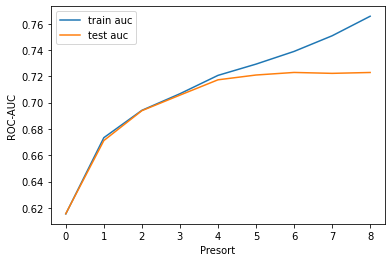

In [19]:
# max_range
auc_train_list = []
auc_test_list = []

for mx_d in range(1,10):
    forest = RandomForestClassifier(max_depth=mx_d,max_features=None, n_estimators=10)
    forest.fit(X_train[selected_heads], y_train )
    predict_test = forest.predict_proba(X_test[selected_heads] )[:,1]
    predict_train = forest.predict_proba(X_train[selected_heads] )[:,1]
    
    auc_test = roc_auc_score(y_test, predict_test )
    auc_train = roc_auc_score(y_train, predict_train )
    print(auc_train, auc_test )
    
    auc_train_list.append(auc_train)
    auc_test_list.append(auc_test)
    
plt.plot(auc_train_list, label = 'train auc')
plt.plot(auc_test_list, label = 'test auc')
plt.xlabel('max_range')
plt.ylabel('ROC-AUC')
plt.legend()
plt.show()

0.7160913908407321 0.7070357898249191
0.7173968918683997 0.7091872273560329
0.7166615288411924 0.7107244894935739
0.7195742371873323 0.7158750454663105


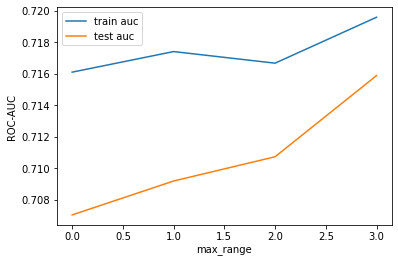

In [20]:
# max_features
auc_train_list = []
auc_test_list = []

mx_fch=["auto", "sqrt", "log2", None]

for i, mx in enumerate(mx_fch):
    forest = RandomForestClassifier(max_depth=5,max_features=mx, n_estimators=10)
    forest.fit(X_train[selected_heads], y_train )
    predict_test = forest.predict_proba(X_test[selected_heads] )[:,1]
    predict_train = forest.predict_proba(X_train[selected_heads] )[:,1]
    
    auc_test = roc_auc_score(y_test, predict_test )
    auc_train = roc_auc_score(y_train, predict_train )
    print(auc_train, auc_test )
    
    auc_train_list.append(auc_train)
    auc_test_list.append(auc_test)
    
plt.plot(auc_train_list, label = 'train auc')
plt.plot(auc_test_list, label = 'test auc')
plt.xlabel('max_features')
plt.ylabel('ROC-AUC')
plt.legend()
plt.show()

0.7194106449876398 0.7152786348605185
0.7202664142309085 0.7165745545210765
0.7208312660130543 0.7172871385916069
0.720715730458451 0.7170882171742475
0.7215809369046693 0.7180526515030125
0.7210472033603351 0.7173542126241342
0.7212483757148597 0.7173994932042868
0.7215851193445402 0.7177147998782835
0.721458529408517 0.717532616618815


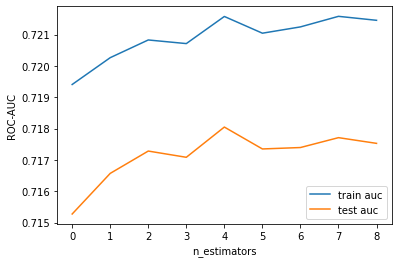

In [22]:
# n_estimators
auc_train_list = []
auc_test_list = []

for n_es in range(10,100,10):
    forest = RandomForestClassifier(max_depth=5,max_features=None, n_estimators=n_es)
    forest.fit(X_train[selected_heads], y_train )
    predict_test = forest.predict_proba(X_test[selected_heads] )[:,1]
    predict_train = forest.predict_proba(X_train[selected_heads] )[:,1]
    
    auc_test = roc_auc_score(y_test, predict_test )
    auc_train = roc_auc_score(y_train, predict_train )
    print(auc_train, auc_test )
    
    auc_train_list.append(auc_train)
    auc_test_list.append(auc_test)
    
plt.plot(auc_train_list, label = 'train auc')
plt.plot(auc_test_list, label = 'test auc')
plt.xlabel('n_estimators')
plt.ylabel('ROC-AUC')
plt.legend()
plt.show()

In [26]:
param_grid = {'max_depth': range(1,10),
              'max_features':["auto", "sqrt", "log2", None],
              'n_estimators': range(10,100,10)
             }
tree = RandomForestClassifier()

In [27]:
grid_search = GridSearchCV(tree, param_grid=param_grid)
grid_search.fit(X_train[selected_heads], y_train)

print(grid_search.best_params_, grid_search.best_score_)

KeyboardInterrupt: 

In [ ]:
n_iter_search = 20
random_search = RandomizedSearchCV(tree, param_distributions=param_grid,
                                   n_iter=n_iter_search)
random_search.fit(X_train[selected_heads], y_train)

print(random_search.best_params_, random_search.best_score_)

# Отбор признаков 

In [42]:
forest = RandomForestClassifier(max_depth=5,max_features=None, n_estimators=50)
forest.fit(X_train[selected_heads], y_train )
predict_test = forest.predict_proba(X_test[selected_heads] )[:,1]
predict_train = forest.predict_proba(X_train[selected_heads] )[:,1]
imp = forest.feature_importances_

best_features = np.c_[imp, selected_heads]
print(best_features)

[['0.0012119855988765576' 'SK_ID_CURR']
 ['0.0014317960369003675' 'AMT_INCOME_TOTAL']
 ['0.002678207315510586' 'AMT_ANNUITY']
 ['0.0012541256329031674' 'AMT_CREDIT']
 ['0.00034223914849613747' 'REGION_POPULATION_RELATIVE']
 ['0.0005392061745408002' 'OWN_CAR_AGE']
 ['0.016388864060138775' 'FLAG_EMP_PHONE']
 ['2.8648449992548107e-05' 'FLAG_WORK_PHONE']
 ['0.0' 'FLAG_PHONE']
 ['0.0002503530656117836' 'REGION_RATING_CLIENT']
 ['0.0005972367823026459' 'HOUR_APPR_PROCESS_START']
 ['0.0' 'REG_REGION_NOT_WORK_REGION']
 ['0.0' 'LIVE_REGION_NOT_WORK_REGION']
 ['0.0011049362843070815' 'REG_CITY_NOT_LIVE_CITY']
 ['0.00033365159511582795' 'REG_CITY_NOT_WORK_CITY']
 ['0.0' 'LIVE_CITY_NOT_WORK_CITY']
 ['0.057082413248807515' 'EXT_SOURCE_1']
 ['0.4778865089988467' 'EXT_SOURCE_2']
 ['0.4272086652166807' 'EXT_SOURCE_3']
 ['0.00031169266844863067' 'APARTMENTS_AVG']
 ['0.0001764230705631573' 'BASEMENTAREA_AVG']
 ['0.0010231059597293883' 'YEARS_BUILD_AVG']
 ['0.0007536385481889536' 'ENTRANCES_AVG']
 ['8.20

In [51]:
# top 5 features
five_features = [] # инициализация
five_features = ['EXT_SOURCE_2', 'EXT_SOURCE_3', 'FLAG_DOCUMENT_3', 'FLAG_EMP_PHONE', 'EXT_SOURCE_1']

In [53]:
# top 5 features

forest = RandomForestClassifier(max_depth=5,max_features=None, n_estimators=50)
forest.fit(X_train[selected_heads], y_train )
predict_test = forest.predict_proba(X_test[selected_heads] )[:,1]
predict_train = forest.predict_proba(X_train[selected_heads] )[:,1]
    
auc_test = roc_auc_score(y_test, predict_test )
auc_train = roc_auc_score(y_train, predict_train )
print(auc_train, auc_test )
    

0.7213064283280133 0.7178255881546144


# Задание № 4
**"Теперь отберите только 5 самых важных и постройте модель только на них. Как изменилась метрика на кросс-валидации? Прокомментируйте"** 

all_features  0.7213064283280133 0.7178255881546144   
top5_features 0.720525145873007 0.7171291161033082

Результат с только пятью наиболее значимыми результатами ухучшился, но не существенно. Если нет переобучения, то чем больше признаков, тем точнее результат. Причем, чем больше вес признака, который мы добавили - тем сильнее он улучшает результат.

In [55]:
# M-1 features

# наиболее значимая фичас с весом 
selected_heads.remove('EXT_SOURCE_2')

forest = RandomForestClassifier(max_depth=5,max_features=None, n_estimators=50)
forest.fit(X_train[selected_heads], y_train )
predict_test = forest.predict_proba(X_test[selected_heads] )[:,1]
predict_train = forest.predict_proba(X_train[selected_heads] )[:,1]
    
auc_test = roc_auc_score(y_test, predict_test )
auc_train = roc_auc_score(y_train, predict_train )
print(auc_train, auc_test )

0.698135618342305 0.6918454816871833


# Задание №5
M_features    0.7213064283280133 0.7178255881546144  
**M-1_feautes   0.698135618342305 0.6918454816871833**  
top5_features 0.7140712388730092 0.7104814414650065  

Суждение аналогично заданию №4. Убрав наиболее весомый признак, мы существенно ухудшили результат, даже сильнее, чем когда были убраны 26 признаков сразу, но наименее значимых